<a href="https://colab.research.google.com/github/JFMitu/JFMitu/blob/main/data2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install torch torchvision timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.5 MB/s eta 0:00:00


In [4]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.models as models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [5]:
# Define paths for the dataIset
data_dir = '/content/drive/MyDrive/RiceLeafsDisease2023'
batch_size = 32

In [6]:
import torch
from torchvision import datasets, transforms

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
# Load the entire dataset from Google Drive
dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)

In [8]:

# Calculate the sizes of train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

In [9]:
print("Total Size:", train_size+test_size+val_size)
print("Train Size:", train_size)
print("Test Size:", test_size)
print("validation Size:", test_size)

Total Size: 2628
Train Size: 1839
Test Size: 395
validation Size: 395


In [10]:
# Create data loaders for train, validation, and test sets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [11]:
num_classes = len(dataset.classes)
print("Number of classes: ", num_classes)

Number of classes:  6


In [12]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3

# Load the InceptionV3 model
inception_model = InceptionV3(weights='imagenet')
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Print model summary
inception_model.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)        

In [13]:
from timm.models.inception_v3 import inception_v3
class inception_v3(nn.Module):
    def __init__(self, num_classes):
        super(inception_v3, self).__init__()
        self.inception_v3 = models.inception_v3(pretrained=True)
        in_features = self.inception_v3.fc.in_features
        self.inception_v3.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.inception_v3(x)

In [14]:
import timm
import torch.nn as nn
import torch.optim as optim

# Define the model architecture (timm's Inception V3)
model = timm.create_model('inception_v3', pretrained=True)

num_classes = len(dataset.classes)

model.fc = nn.Linear(model.fc.in_features, num_classes)  # Adjust the final fully connected layer

# Move the model to a suitable device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

InceptionV3(
  (Conv2d_1a_3x3): ConvNormAct(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (Conv2d_2a_3x3): ConvNormAct(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (Conv2d_2b_3x3): ConvNormAct(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (Pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): ConvNormAct(
    (conv): Conv2d(64, 80, kernel_size

In [15]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
# Train the model
# Training loop
num_epochs = 30
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions_train = 0
    total_samples_train = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_samples_train += labels.size(0)
        correct_predictions_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracy = correct_predictions_train / total_samples_train
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    running_val_loss = 0.0
    correct_predictions_val = 0
    total_samples_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_samples_val += labels.size(0)
            correct_predictions_val += (predicted == labels).sum().item()

    val_losses.append(running_val_loss / len(val_loader))
    val_accuracy = correct_predictions_val / total_samples_val
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_losses[-1]:.6f} - Train Acc: {train_accuracy*100:.2f}% - Val Loss: {val_losses[-1]:.6f} - Val Acc: {val_accuracy*100:.2f}%")
print("Finished Training")

Epoch [1/30] - Train Loss: 0.732951 - Train Acc: 74.61% - Val Loss: 1.243349 - Val Acc: 72.34%
Epoch [2/30] - Train Loss: 0.445876 - Train Acc: 85.43% - Val Loss: 0.399262 - Val Acc: 85.28%
Epoch [3/30] - Train Loss: 0.330143 - Train Acc: 89.40% - Val Loss: 0.442434 - Val Acc: 83.25%
Epoch [4/30] - Train Loss: 0.234708 - Train Acc: 91.95% - Val Loss: 0.306882 - Val Acc: 89.85%
Epoch [5/30] - Train Loss: 0.194799 - Train Acc: 94.51% - Val Loss: 0.140579 - Val Acc: 96.19%
Epoch [6/30] - Train Loss: 0.124511 - Train Acc: 96.41% - Val Loss: 1.123259 - Val Acc: 66.50%
Epoch [7/30] - Train Loss: 0.233130 - Train Acc: 92.55% - Val Loss: 0.272082 - Val Acc: 92.89%
Epoch [8/30] - Train Loss: 0.171225 - Train Acc: 94.56% - Val Loss: 0.218864 - Val Acc: 92.89%
Epoch [9/30] - Train Loss: 0.169135 - Train Acc: 94.67% - Val Loss: 0.198842 - Val Acc: 91.88%
Epoch [10/30] - Train Loss: 0.135046 - Train Acc: 95.76% - Val Loss: 0.244791 - Val Acc: 92.39%
Epoch [11/30] - Train Loss: 0.166006 - Train Acc:

In [17]:
# Testing loop
test_accuracies = []

model.eval()
correct_predictions_test = 0
total_samples_test = 0

class_correct = [0] * len(train_dataset.dataset.classes)  # Use train_dataset.dataset.classes
class_total = [0] * len(train_dataset.dataset.classes)    # Use train_dataset.dataset.classes

predicted_labels = []
actual_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total_samples_test += labels.size(0)
        correct_predictions_test += (predicted == labels).sum().item()

        # Store predicted and actual labels
        predicted_labels.extend(predicted.tolist())
        actual_labels.extend(labels.tolist())

        # Calculate correct predictions for each class
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += (predicted[i] == label).item()
            class_total[label] += 1

    test_accuracy = correct_predictions_test / total_samples_test
    test_accuracies.append(test_accuracy)
    print(f"Testing Accuracy: {test_accuracy*100:.2f}%")
    print(f"Total Correct Predictions on Test Set: {correct_predictions_test} out of {total_samples_test} samples")

Testing Accuracy: 94.18%
Total Correct Predictions on Test Set: 372 out of 395 samples


In [18]:
pip install matplotlib

In [19]:
!pip install tabulate

In [20]:
from tabulate import tabulate
# Print predicted and actual labels in a table
table_data = []
for i in range(len(predicted_labels)):
    table_data.append([i + 1, test_dataset.dataset.classes[predicted_labels[i]], test_dataset.dataset.classes[actual_labels[i]]])

table_headers = ["Sample", "Predicted Label", "Actual Label"]
print(tabulate(table_data, headers=table_headers, tablefmt="grid"))

+----------+-----------------------+-----------------------+
|   Sample | Predicted Label       | Actual Label          |
+==========+=======================+=======================+
|        1 | Leaf Scald            | Narrow Brown Spot     |
+----------+-----------------------+-----------------------+
|        2 | Healthy               | Healthy               |
+----------+-----------------------+-----------------------+
|        3 | Narrow Brown Spot     | Narrow Brown Spot     |
+----------+-----------------------+-----------------------+
|        4 | Bacterial Leaf Blight | Bacterial Leaf Blight |
+----------+-----------------------+-----------------------+
|        5 | Narrow Brown Spot     | Narrow Brown Spot     |
+----------+-----------------------+-----------------------+
|        6 | Brown Spot            | Brown Spot            |
+----------+-----------------------+-----------------------+
|        7 | Leaf Scald            | Leaf Scald            |
+----------+------------

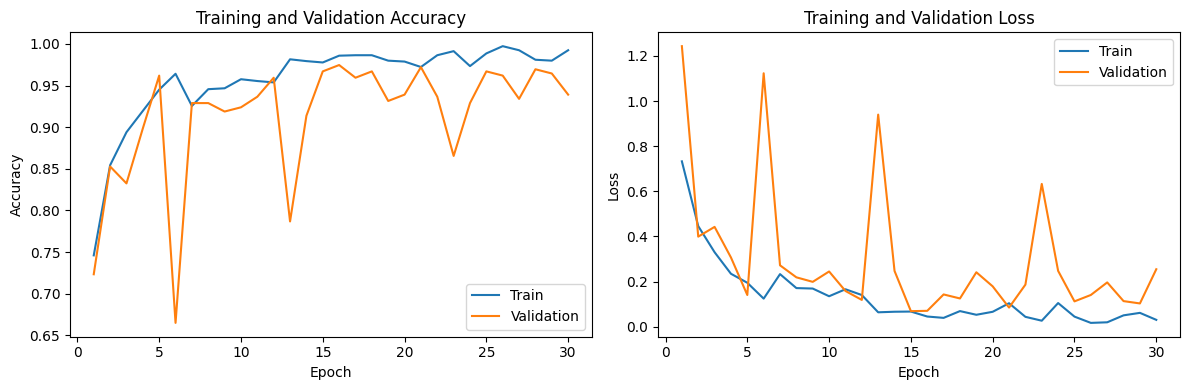

In [21]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [35]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import seaborn as sns

# Calculate precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(actual_labels, predicted_labels, average='weighted')

# Create a table with weighted precision, recall, and F1-score
weighted_metrics = [["Weighted", precision, recall, f1]]

table_headers = ["Class", "Precision", "Recall", "F1-score"]
print(tabulate(weighted_metrics, headers=table_headers, tablefmt="grid"))


# Calculate confusion matrix
conf_matrix = confusion_matrix(actual_labels, predicted_labels)
# Print confusion matrix
print("\nConfusion Matrix:")
print(conf_matrix)


+----------+-------------+----------+------------+
| Class    |   Precision |   Recall |   F1-score |
+==========+=============+==========+============+
| Weighted |    0.945165 | 0.941772 |   0.940377 |
+----------+-------------+----------+------------+

Confusion Matrix:
[[61  0  0  0  2  0]
 [ 0 47  0 15  0  2]
 [ 0  0 72  0  0  0]
 [ 0  3  0 75  0  0]
 [ 0  0  0  0 58  0]
 [ 0  0  0  0  1 59]]


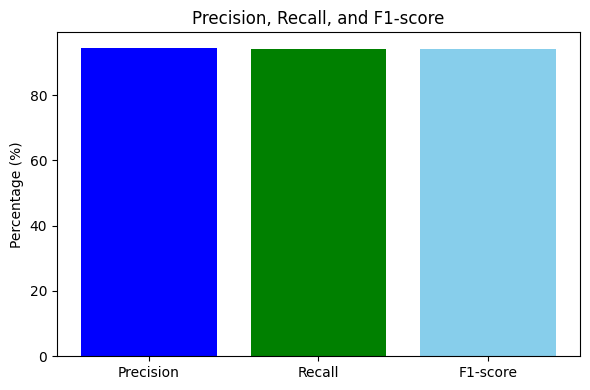

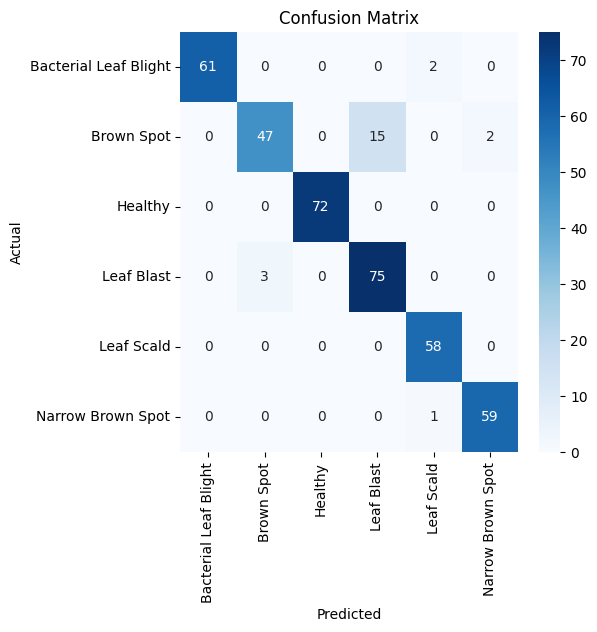

In [36]:
precision_percent = precision * 100
recall_percent = recall * 100
f1_percent = f1 * 100

metrics = ['Precision', 'Recall', 'F1-score']
values = [precision_percent, recall_percent, f1_percent]

plt.figure(figsize=(6, 4))
plt.bar(metrics, values, color=['blue', 'green', 'skyblue'])
plt.ylabel('Percentage (%)')
plt.title('Precision, Recall, and F1-score')
plt.tight_layout()
plt.show()

# Plot confusion matrix
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.dataset.classes, yticklabels=test_dataset.dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [37]:
table_data = []
for i, class_name in enumerate(test_dataset.dataset.classes):
    accuracy = class_correct[i] / class_total[i] * 100 if class_total[i] > 0 else 0.0
    table_data.append([class_name, class_correct[i], class_total[i], f"{accuracy:.2f}%"])

table_headers = ["Class", "Correct", "Total", "Accuracy"]
print(tabulate(table_data, headers=table_headers, tablefmt="grid"))

+-----------------------+-----------+---------+------------+
| Class                 |   Correct |   Total | Accuracy   |
+=======================+===========+=========+============+
| Bacterial Leaf Blight |        61 |      63 | 96.83%     |
+-----------------------+-----------+---------+------------+
| Brown Spot            |        47 |      64 | 73.44%     |
+-----------------------+-----------+---------+------------+
| Healthy               |        72 |      72 | 100.00%    |
+-----------------------+-----------+---------+------------+
| Leaf Blast            |        75 |      78 | 96.15%     |
+-----------------------+-----------+---------+------------+
| Leaf Scald            |        58 |      58 | 100.00%    |
+-----------------------+-----------+---------+------------+
| Narrow Brown Spot     |        59 |      60 | 98.33%     |
+-----------------------+-----------+---------+------------+


In [39]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
# Calculate precision, recall, and F1 score
precision = precision_score(actual_labels, predicted_labels, average='weighted')
recall = recall_score(actual_labels, predicted_labels, average='weighted')
f1 = f1_score(actual_labels, predicted_labels, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.9452
Recall: 0.9418
F1 Score: 0.9404


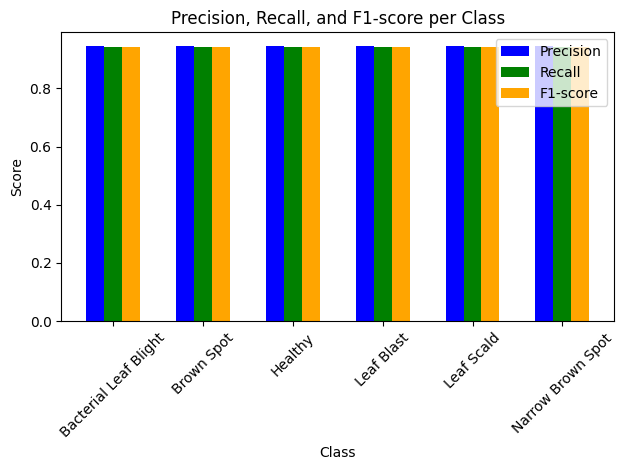

In [40]:
# Plot precision, recall, and F1-score
x = np.arange(len(test_dataset.dataset.classes))
width = 0.2

plt.bar(x - width, precision, width, label='Precision', color='blue')
plt.bar(x, recall, width, label='Recall', color='green')
plt.bar(x + width, f1, width, label='F1-score', color='orange')

plt.xlabel("Class")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1-score per Class")
plt.xticks(x, test_dataset.dataset.classes, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()